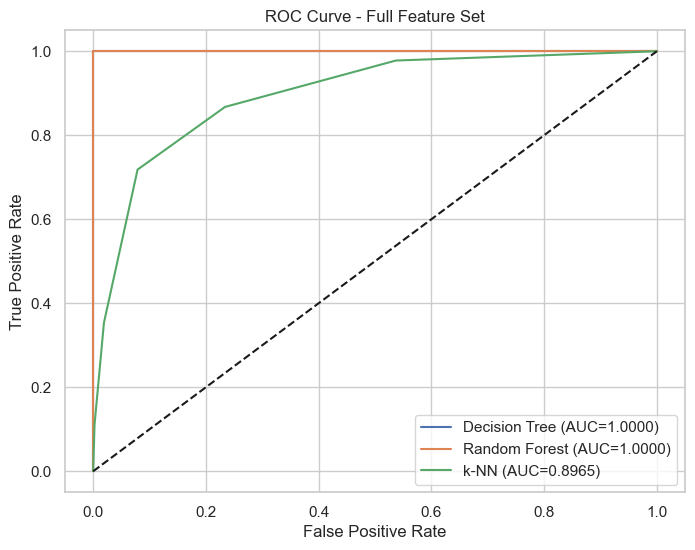

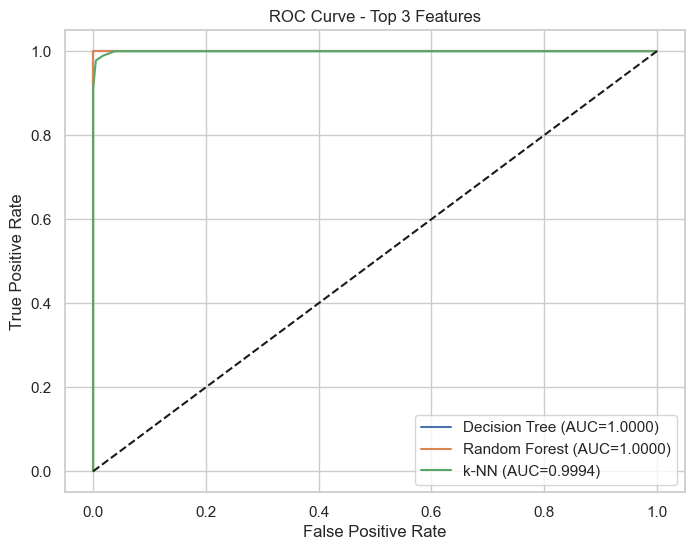


Model Performance Comparison

Decision Tree
Full - Accuracy: 1.0000, ROC AUC: 1.0000
Top 3 - Accuracy: 1.0000, ROC AUC: 1.0000

Random Forest
Full - Accuracy: 1.0000, ROC AUC: 1.0000
Top 3 - Accuracy: 1.0000, ROC AUC: 1.0000

k-NN
Full - Accuracy: 0.8600, ROC AUC: 0.8965
Top 3 - Accuracy: 0.9850, ROC AUC: 0.9994


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

# Load data
data = pd.read_csv("./mental_health_workplace_survey.csv")

# Drop unneeded columns
data = data.drop(columns=["EmployeeID"])

# Define target and features
X = data.drop("BurnoutRisk", axis=1)
y = data["BurnoutRisk"]

# Train-Test Split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

categorical_features = [col for col in X_train.columns if X_train[col].dtype == "object"]
numerical_features = [col for col in X_train.columns if col not in categorical_features]

#Increases k-NN accuracy even though I don't see any missing values --Doubt
for col in categorical_features:
    X_train[col].fillna(X_train[col].mode()[0], inplace=True)
    X_valid[col].fillna(X_train[col].mode()[0], inplace=True)

for col in numerical_features:
    X_train[col].fillna(X_train[col].median(), inplace=True)
    X_valid[col].fillna(X_train[col].median(), inplace=True) 
    
# Encode categorical variables
encoder = OrdinalEncoder()
X_train[categorical_features] = encoder.fit_transform(X_train[categorical_features])
X_valid[categorical_features] = encoder.transform(X_valid[categorical_features])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Full Feature Training
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "k-NN": KNeighborsClassifier()
}

results_full = {}
plt.figure(figsize=(8, 6))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_valid_scaled)
    y_proba = model.predict_proba(X_valid_scaled)[:, 1]

    acc = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_proba)

    results_full[name] = {"Accuracy": acc, "ROC AUC": roc_auc}

    fpr, tpr, _ = roc_curve(y_valid, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Full Feature Set")
plt.legend()
plt.show()

# Top 3 Feature selection using Mutual Information (Through SelectKBest)
selector = SelectKBest(score_func=mutual_info_classif,k=3)
selector.fit(X_train_scaled, y_train)

selected_features_mask = selector.get_support() #Getting the True/False array of the selected/non-selected columns
selected_features = X_train.columns[selected_features_mask] #Getting the columns

# Filter features
X_train_selected = X_train_scaled[:, selected_features_mask] 
X_valid_selected = X_valid_scaled[:, selected_features_mask]

# Scale selected features again
X_train_top_scaled = scaler.fit_transform(X_train_selected)
X_valid_top_scaled = scaler.transform(X_valid_selected)

results_top3 = {}
plt.figure(figsize=(8, 6))

for name, model in models.items():
    model.fit(X_train_top_scaled, y_train)
    y_pred = model.predict(X_valid_top_scaled)
    y_proba = model.predict_proba(X_valid_top_scaled)[:, 1]  #From GFG

    acc = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_proba)

    results_top3[name] = {"Accuracy": acc, "ROC AUC": roc_auc}

    fpr, tpr, _ = roc_curve(y_valid, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.4f})")  #From GFG

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Top 3 Features")
plt.legend()
plt.show()

# Comparison
print("\nModel Performance Comparison")
for name in models:
    print(f"\n{name}")
    print(f"Full - Accuracy: {results_full[name]['Accuracy']:.4f}, ROC AUC: {results_full[name]['ROC AUC']:.4f}")
    print(f"Top 3 - Accuracy: {results_top3[name]['Accuracy']:.4f}, ROC AUC: {results_top3[name]['ROC AUC']:.4f}")
